In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
from glob import glob 
import itertools
import os
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.python.framework import ops
ops.reset_default_graph()
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# GLOBAL VARIABLES
scale = 70
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
os.listdir("./train")

['Sugar beet',
 'Scentless Mayweed',
 'Maize',
 'Common Chickweed',
 'Black-grass',
 'Fat Hen',
 'Cleavers',
 'Charlock',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Common wheat',
 'Shepherds Purse']

In [3]:
imagesTrainPath = 'train/*/*.png'
imagesTestPath = 'test/*.png'
trainImages = glob(imagesTrainPath)
testImages  = glob(imagesTestPath)
trainingset = []
traininglabels = []
testset = []
testlabels = []
trainSize = len(trainImages)
testSize  = len(testImages)

In [4]:
cnt = 1
for i in trainImages:
    print(str(cnt)+'/'+str(trainSize),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    cnt = cnt + 1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

In [5]:
print(trainSize, len(trainingset), len(traininglabels))

4750 4750 4750


In [6]:
cnt = 1
for i in testImages:
    print(str(cnt)+'/'+str(testSize),end='\r')
    testlabels.append(i.split('/')[-1])
    testset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    cnt = cnt + 1
testset = np.asarray(testset)

In [7]:
print(testSize, len(testset))

794 794


(491, 491, 3) (70, 70, 3)


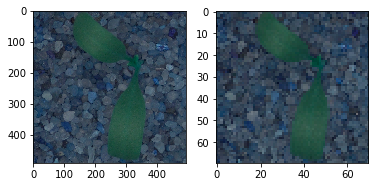

In [8]:
sampleImageScale = trainingset[1]
sampleImageOriginal = cv2.imread(trainImages[1])
print(sampleImageOriginal.shape, sampleImageScale.shape)
plt.subplot(1,2,1)
plt.imshow(sampleImageOriginal)
plt.subplot(1,2,2)
plt.imshow(sampleImageScale)

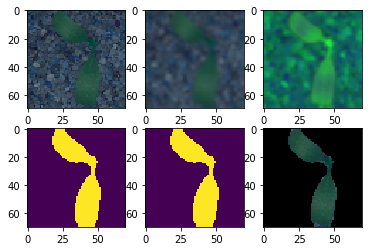

In [9]:
blurr = cv2.GaussianBlur(sampleImageScale,(5,5),0)
hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
lower = (25,40,50)
upper = (75,255,255)
mask = cv2.inRange(hsv,lower,upper)
struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
boolean = mask>0
new = np.zeros_like(sampleImageScale,np.uint8)
new[boolean] = sampleImageScale[boolean]
plt.subplot(2,3,1);plt.imshow(sampleImageScale)
plt.subplot(2,3,2);plt.imshow(blurr)
plt.subplot(2,3,3);plt.imshow(hsv)
plt.subplot(2,3,4);plt.imshow(mask)
plt.subplot(2,3,5);plt.imshow(boolean)
plt.subplot(2,3,6);plt.imshow(new)
plt.show()

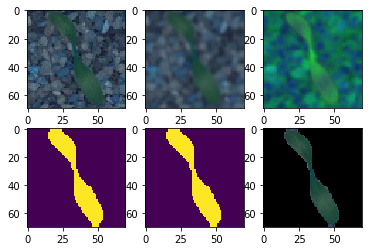

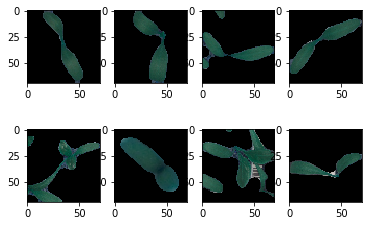

In [10]:
trainNew = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    trainNew.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask) 
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(new) 
        plt.show()
        getEx = False
trainNew = np.asarray(trainNew)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(trainNew[i])

LabelEncoder()

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


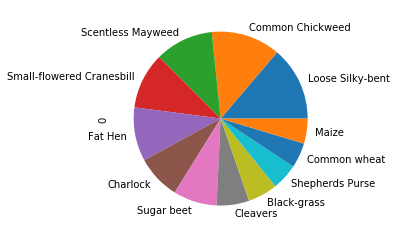

In [11]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [12]:
trainNew = trainNew/255
x_train,x_test,y_train,y_test = train_test_split(trainNew,clearalllabels,test_size=0.1,
                                                 random_state=SEED,stratify=clearalllabels)

In [13]:
print(len(x_train),len(x_test))

4275 475


In [14]:
EPOCHS=15
BATCH_SIZE=75

modelBasic = Sequential()

modelBasic.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
modelBasic.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
modelBasic.add(MaxPooling2D((2, 2)))
modelBasic.add(BatchNormalization(axis=3))
modelBasic.add(Dropout(0.1))

modelBasic.add(Flatten())

modelBasic.add(Dense(classes, activation='softmax'))

modelBasic.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

modelBasic.summary()
modelBasic.fit(x_train, y_train, batch_size=BATCH_SIZE, nb_epoch=EPOCHS, validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)  

/conda/envs/rapids/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4275 samples, validate on 475 samples
Epoch 1/15
4275/4275 [==============================] - 8s 2ms/step - loss: 1.5072 - acc: 0.5060 - val_loss: 4.2876 - val_acc: 0.2379
Epoch 2/15
4275/4275 [==============================] - 5s 1ms/step - loss: 0.8007 - acc: 0.7294 - val_loss: 1.8222 - val_acc: 0.5747
Epoch 3/15
4275/4275 [==============================] - 5s 1ms/step - loss: 0.4748 - acc: 0.8414 - val_loss: 1.8696 - val_acc: 0.5958
Epoch 4/15
4275/4275 [==============================] - 6s 1ms/step - loss: 0.2693 - acc: 0.9172 - val_loss: 1.7808 - val_acc: 0.5642
Epoch 5/15
4275/4275 [==============================] - 5s 1ms/step - loss: 0.1389 - acc: 0.9591 - val_loss: 1.7409 - val_acc: 0.6484
Epoch 6/15
4275/4275 [==============================] - 6s 1ms/step - loss: 0.0701 - acc: 0.9818 - val_loss: 2.2095 - val_acc: 0.6105
Epoch 7/15
4275/4275 [==============================] - 6s 1ms/step - loss: 0.0453 - acc: 0.9876 - val_loss: 2.5422 - val_acc: 0.5663
Epoch 8/15
4275

In [16]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_2 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 128)       204928    
__________

In [17]:
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=2, 
                        factor=0.4, 
                        min_lr=0.00001)

filepath="weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', 
                              verbose=2, save_best_only=True, mode='max')
filepath="weights.last_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=2, save_best_only=False, mode='max')

callbacks_list = [checkpoints, lrr, checkpoints_full]

In [18]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,
                               height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [19]:
datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")
EPOCHS=35
BATCH_SIZE=35
model.fit_generator(generator.flow(x_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch=len(x_train) / BATCH_SIZE, 
                    epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=callbacks_list)


datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")

'07.Jul 2019 09:19:43'

Epoch 1/35
123/122 [==============================] - 17s 137ms/step - loss: 2.6037 - acc: 0.2613 - val_loss: 3.2502 - val_acc: 0.3263

Epoch 00001: val_acc improved from -inf to 0.32632, saving model to weights.best_01-0.33.hdf5

Epoch 00001: saving model to weights.last_auto4.hdf5
Epoch 2/35
123/122 [==============================] - 14s 111ms/step - loss: 1.9909 - acc: 0.3633 - val_loss: 2.1212 - val_acc: 0.3326

Epoch 00002: val_acc improved from 0.32632 to 0.33263, saving model to weights.best_02-0.33.hdf5

Epoch 00002: saving model to weights.last_auto4.hdf5
Epoch 3/35
123/122 [==============================] - 14s 110ms/step - loss: 1.7423 - acc: 0.4128 - val_loss: 1.9054 - val_acc: 0.4716

Epoch 00003: val_acc improved from 0.33263 to 0.47158, saving model to weights.best_03-0.47.hdf5

Epoch 00003: saving model to weights.last_auto4.hdf5
Epoch 4/35
123/122 [==============================] - 13s 109ms/step - loss: 1.5591 - acc: 0.4697 - val_loss: 1.2565 - val_acc: 0.5558

Epoch 

'07.Jul 2019 09:27:47'

In [20]:
print(model.evaluate(x_train, y_train)) 

4275/4275 [==============================] - 4s 955us/step
[0.23113185096205327, 0.9132163743247763]


In [21]:
print(model.evaluate(x_test, y_test))

475/475 [==============================] - 1s 1ms/step
[0.2695108555492602, 0.9010526307005632]


In [22]:
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 
cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[ 6  0  0  0  3  0 17  0  0  0  0  0]
 [ 0 33  2  0  0  0  0  0  0  1  3  0]
 [ 0  0 29  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 58  0  0  0  0  2  0  1  0]
 [ 0  0  0  0 21  0  1  0  0  0  0  0]
 [ 0  0  0  0  0 44  0  1  0  0  1  1]
 [ 4  0  0  0  0  0 60  0  1  0  0  0]
 [ 0  0  0  0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0  0  3  0 49  0  0  0]
 [ 0  0  0  0  0  0  0  0  3 19  0  1]
 [ 0  0  1  0  0  0  0  0  0  0 49  0]
 [ 0  0  0  0  0  0  0  0  1  0  0 38]]


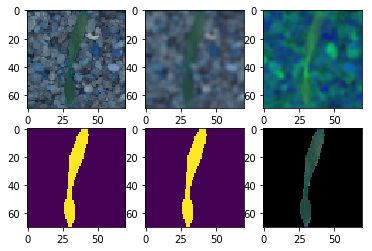

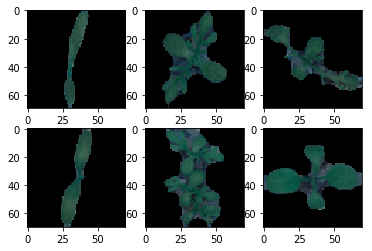

In [23]:
newtestimages = []
sets = []
getEx = True
for i in testset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])